In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 1 Logical GPU


2024-02-15 11:43:51.129794: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-15 11:43:51.129813: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-15 11:43:51.129816: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-15 11:43:51.130137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-15 11:43:51.130410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0


In [3]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Reshape data for SVD
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

avg=int(round(x_test.shape[1]+ x_test.shape[2]))

# Apply SVD
n_components = avg  # You can vary this
svd = TruncatedSVD(n_components=n_components)
x_train_svd = svd.fit_transform(x_train_flat)
x_test_svd = svd.transform(x_test_flat)

# Reshape data back for CNN input
# Adjusted reshape for the SVD output
x_train_svd = x_train_svd.reshape(x_train.shape[0], n_components, 1, 1)
x_test_svd = x_test_svd.reshape(x_test.shape[0], n_components, 1, 1)


In [4]:
# Convert the data to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_svd, y_train))

# Define a function for data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(augment)


In [5]:
# Adjusted model for SVD output
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_components, 1, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Epoch 1/5
   1/1875 [..............................] - ETA: 10:52 - loss: 2.9755 - accuracy: 0.1562

2024-02-15 11:44:00.220215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 8s 4ms/step - loss: 0.4774 - accuracy: 0.8601
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3744 - accuracy: 0.8934
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3757 - accuracy: 0.8942
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3807 - accuracy: 0.8936
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3830 - accuracy: 0.8933


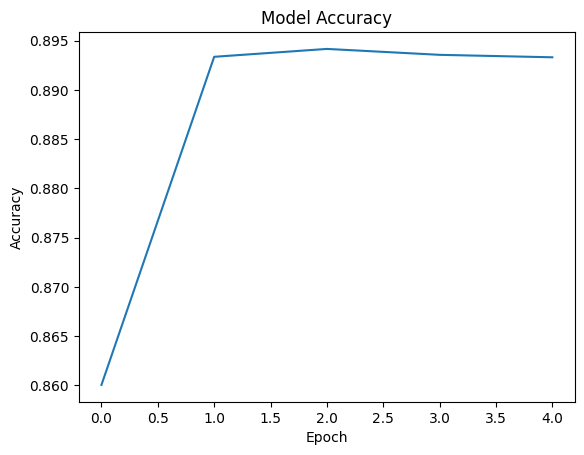

In [6]:
# Lists to store accuracy values for plotting
history = model.fit(train_dataset.batch(32), epochs=5)

# Plot accuracy per epoch
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [7]:
# Evaluate the model on the test data
model.evaluate(x_test_svd, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3969 - accuracy: 0.8894


[0.3969402313232422, 0.8894000053405762]